In [8]:
%%capture
# ===== Install compatible versions for Kaggle =====
# key idea:
# - use numpy 1.26.x (plays nice with tensorflow, scipy, filterpy)
# - use scipy that matches this numpy
# - install ultralytics + filterpy on top

%pip install -q --root-user-action=ignore \
    "numpy==1.26.4" \
    "scipy==1.13.1" \
    "ultralytics==8.3.49" \
    "filterpy==1.4.5"
import os
import math
import time
import glob
import cv2
import numpy as np
import pandas as pd
import torch

from ultralytics import YOLO
from filterpy.kalman import KalmanFilter
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt


In [9]:
# =======================================
# Cell 2: Paths and sequence definitions
# =======================================

BASE_DIR = "/kaggle/input/adspmini02"  # <-- change if your dataset name differs

TRAIN_VIDEO_DIR = os.path.join(BASE_DIR, "Train", "vedios")
TRAIN_GT_DIR    = os.path.join(BASE_DIR, "Train", "gt")

TEST_VIDEO_DIR  = os.path.join(BASE_DIR, "Test", "vedios")
TEST_GT_DIR     = os.path.join(BASE_DIR, "Test", "gt")

OUTPUT_DIR = "/kaggle/working/wildlife_tracking"
YOLO_BASE  = "/kaggle/working/yolo_data"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(YOLO_BASE, exist_ok=True)

def build_sequences(video_dir, gt_dir):
    """
    Build a dict:
        {
          seq_name: {
             "video": path/to/video.mp4 (or None),
             "gt":    path/to/gt.txt    (or None)
          },
          ...
        }

    If GT files are named like `deer_1_gt.txt` and videos are `deer_1.mp4`,
    we strip the trailing '_gt' from the GT base name so they match.
    """
    seqs = {}

    # ---- collect videos ----
    if os.path.exists(video_dir):
        for pattern in ("*.mp4", "*.avi", "*.mov"):
            for vpath in sorted(glob.glob(os.path.join(video_dir, pattern))):
                base = os.path.splitext(os.path.basename(vpath))[0]
                seqs.setdefault(base, {})["video"] = vpath
    else:
        print("Missing video dir:", video_dir)

    # ---- collect GTs (strip '_gt') ----
    if os.path.exists(gt_dir):
        for gpath in sorted(glob.glob(os.path.join(gt_dir, "*.txt"))):
            base = os.path.splitext(os.path.basename(gpath))[0]
            # e.g. 'deer_1_gt' -> 'deer_1'
            if base.endswith("_gt"):
                base = base[:-3]
            seqs.setdefault(base, {})["gt"] = gpath
    else:
        print("Missing GT dir:", gt_dir)

    # ensure both keys exist for all sequences
    for k, v in seqs.items():
        v.setdefault("video", None)
        v.setdefault("gt", None)

    return seqs

train_seqs = build_sequences(TRAIN_VIDEO_DIR, TRAIN_GT_DIR)
test_seqs  = build_sequences(TEST_VIDEO_DIR, TEST_GT_DIR)

print("Train sequences:")
for k, v in train_seqs.items():
    print(" ", k, "->", v)

print("\nTest sequences:")
for k, v in test_seqs.items():
    print(" ", k, "->", v)


Train sequences:
  deer_1 -> {'video': '/kaggle/input/adspmini02/Train/vedios/deer_1.mp4', 'gt': '/kaggle/input/adspmini02/Train/gt/deer_1_gt.txt'}
  deer_2 -> {'video': '/kaggle/input/adspmini02/Train/vedios/deer_2.mp4', 'gt': '/kaggle/input/adspmini02/Train/gt/deer_2_gt.txt'}
  deer_3 -> {'video': '/kaggle/input/adspmini02/Train/vedios/deer_3.mp4', 'gt': '/kaggle/input/adspmini02/Train/gt/deer_3_gt.txt'}
  deer_4 -> {'video': '/kaggle/input/adspmini02/Train/vedios/deer_4.mp4', 'gt': '/kaggle/input/adspmini02/Train/gt/deer_4_gt.txt'}
  deer_7 -> {'video': '/kaggle/input/adspmini02/Train/vedios/deer_7.mp4', 'gt': '/kaggle/input/adspmini02/Train/gt/deer_7_gt.txt'}
  horse_3 -> {'video': '/kaggle/input/adspmini02/Train/vedios/horse_3.mp4', 'gt': '/kaggle/input/adspmini02/Train/gt/horse_3_gt.txt'}
  horse_4 -> {'video': '/kaggle/input/adspmini02/Train/vedios/horse_4.mp4', 'gt': '/kaggle/input/adspmini02/Train/gt/horse_4_gt.txt'}
  horse_5 -> {'video': '/kaggle/input/adspmini02/Train/vedio

In [10]:
# ======================================
# Cell 3: GT loader and class discovery
# ======================================

def load_gt_file(gt_path):
    """
    GT format (MOT-style):
    frame, target_id, x, y, w, h, conf, cls, vis
    """
    cols = ["frame", "gt_id", "x", "y", "w", "h", "conf", "cls", "vis"]
    df = pd.read_csv(
        gt_path,
        header=None,
        names=cols,
        sep=r"[,\s]+",
        engine="python"
    )
    # keep useful cols
    df = df[["frame", "gt_id", "x", "y", "w", "h", "cls"]].copy()
    df["frame"] = df["frame"].astype(int)
    df["gt_id"] = df["gt_id"].astype(int)
    df["cls"]   = df["cls"].astype(int)
    return df

ALL_CLASSES = set()

for seqs in (train_seqs, test_seqs):
    for seq_name, paths in seqs.items():
        gpath = paths.get("gt")
        if not gpath or not os.path.exists(gpath):
            continue
        df = load_gt_file(gpath)
        if df.empty:
            continue
        ALL_CLASSES.update(df["cls"].unique().tolist())

ALL_CLASSES = sorted(int(c) for c in ALL_CLASSES)
print("Unique class IDs in GT:", ALL_CLASSES)

# mapping from GT class IDs to contiguous 0..nc-1 for YOLO
cls_to_new = {old: i for i, old in enumerate(ALL_CLASSES)}
print("Class remap (GT -> YOLO):", cls_to_new)

NC = len(ALL_CLASSES)


Unique class IDs in GT: [2, 6, 8]
Class remap (GT -> YOLO): {2: 0, 6: 1, 8: 2}


In [11]:
# ============================================
# Cell 4: Export Train/Test to YOLO format
# ============================================

IMGS_TRAIN_DIR = os.path.join(YOLO_BASE, "images", "train")
IMGS_VAL_DIR   = os.path.join(YOLO_BASE, "images", "val")
LBL_TRAIN_DIR  = os.path.join(YOLO_BASE, "labels", "train")
LBL_VAL_DIR    = os.path.join(YOLO_BASE, "labels", "val")

for d in [IMGS_TRAIN_DIR, IMGS_VAL_DIR, LBL_TRAIN_DIR, LBL_VAL_DIR]:
    os.makedirs(d, exist_ok=True)

def export_split_to_yolo(split_name, seq_dict, img_out_dir, lbl_out_dir):
    print(f"\nExporting {split_name} split to YOLO format")
    for seq_name, paths in seq_dict.items():
        video_path = paths["video"]
        gt_path    = paths["gt"]
        if video_path is None or gt_path is None:
            print(f"  Skipping {seq_name}: missing video or GT.")
            continue

        print(f"  Processing seq: {seq_name}")
        gt_df = load_gt_file(gt_path)
        if gt_df.empty:
            print("    Empty GT file, skip.")
            continue

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("    Failed to open video:", video_path)
            continue

        w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        frame_idx = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame_idx += 1

            sub = gt_df[gt_df["frame"] == frame_idx]
            if sub.empty:
                continue

            img_name = f"{seq_name}_{frame_idx:06d}.jpg"
            img_path = os.path.join(img_out_dir, img_name)
            lbl_path = os.path.join(lbl_out_dir, img_name.replace(".jpg", ".txt"))

            cv2.imwrite(img_path, frame)

            lines = []
            for _, row in sub.iterrows():
                x, y, bw, bh = row["x"], row["y"], row["w"], row["h"]
                cls_old = int(row["cls"])
                cls_new = cls_to_new[cls_old]

                xc = (x + bw / 2.0) / w
                yc = (y + bh / 2.0) / h
                wn = bw / w
                hn = bh / h

                lines.append(f"{cls_new} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}")

            with open(lbl_path, "w") as f:
                f.write("\n".join(lines))

        cap.release()
        print(f"    Done seq {seq_name}")

export_split_to_yolo("Train", train_seqs, IMGS_TRAIN_DIR, LBL_TRAIN_DIR)
export_split_to_yolo("Test",  test_seqs,  IMGS_VAL_DIR,   LBL_VAL_DIR)
print("\nYOLO export done.")



Exporting Train split to YOLO format
  Processing seq: deer_1
    Done seq deer_1
  Processing seq: deer_2
    Done seq deer_2
  Processing seq: deer_3
    Done seq deer_3
  Processing seq: deer_4
    Done seq deer_4
  Processing seq: deer_7
    Done seq deer_7
  Processing seq: horse_3
    Done seq horse_3
  Processing seq: horse_4
    Done seq horse_4
  Processing seq: horse_5
    Done seq horse_5
  Processing seq: horse_6
    Done seq horse_6
  Processing seq: horse_7
    Done seq horse_7
  Processing seq: pig_1
    Done seq pig_1
  Processing seq: pig_2
    Done seq pig_2
  Processing seq: pig_3
    Done seq pig_3
  Processing seq: pig_5
    Done seq pig_5

Exporting Test split to YOLO format
  Processing seq: deer_5
    Done seq deer_5
  Processing seq: deer_6
    Done seq deer_6
  Processing seq: horse_1
    Done seq horse_1
  Processing seq: horse_2
    Done seq horse_2
  Processing seq: pig_4
    Done seq pig_4

YOLO export done.


In [13]:
# ==================================
# Cell 5: Create data.yaml for YOLO
# ==================================

names_list = [f"cls{c}" for c in ALL_CLASSES]  # default names
names_list_str = "[" + ", ".join(f"'{n}'" for n in names_list) + "]"

data_yaml = f"""# auto-generated
path: {YOLO_BASE}
train: images/train
val: images/val

nc: {NC}
names: {names_list_str}
"""

yaml_path = os.path.join(YOLO_BASE, "data.yaml")
with open(yaml_path, "w") as f:
    f.write(data_yaml)

print("Wrote data.yaml to:", yaml_path)
print(data_yaml)


Wrote data.yaml to: /kaggle/working/yolo_data/data.yaml
# auto-generated
path: /kaggle/working/yolo_data
train: images/train
val: images/val

nc: 3
names: ['cls2', 'cls6', 'cls8']



In [16]:
# ===================================
# Cell 6: Patch Ray bug + train YOLO
# ===================================

# ---- Patch Ray Tune callback so Ultralytics doesn't crash on Kaggle ----
try:
    import ray
    try:
        # Newer Ray versions don't have _get_session; Ultralytics expects it.
        from ray.train import _internal as _ray_internal
        sess = getattr(_ray_internal, "session", None)

        if sess is not None and not hasattr(sess, "_get_session"):
            def _get_session():
                # Returning None means "no Ray Tune session active"
                return None

            sess._get_session = _get_session
            print("✅ Patched ray.train._internal.session._get_session (Ultralytics RayTune callback disabled).")
        else:
            print("Ray session already has _get_session or session is None – no patch needed.")
    except Exception as e:
        print("Ray train internal not patched (this is usually fine):", e)
except ImportError:
    print("Ray is not installed – Ultralytics RayTune callbacks are already disabled.")

# ---- Train YOLOv8 detector ----
from ultralytics import YOLO

det_model = YOLO("yolov8n.pt")  # you can switch to 'yolov8s.pt' etc.

results = det_model.train(
    data=yaml_path,
    imgsz=640,
    epochs=10,
    batch=32,
    # project=RUN_ROOT,
    name="wildlife_det",
    exist_ok=True
)

# Try to get run directory from trainer, fall back to default
try:
    save_dir = det_model.trainer.save_dir
except Exception:
    save_dir = os.path.join(RUN_ROOT, "wildlife_det")

print("\nTraining finished.")
print("Run directory:", save_dir)
print("Best weights path:", getattr(det_model, "best", "see run folder"))


Ray session already has _get_session or session is None – no patch needed.


train: Scanning /kaggle/working/yolo_data/labels/train.cache... 6430 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6430/6430 [00:00<?, ?it/s]
/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /kaggle/working/yolo_data/labels/val.cache... 1442 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1442/1442 [00:00<?, ?it/s]
/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
       1/10      4.43G      1.203      1.379      1.122        390        640: 100%|██████████| 201/201 [01:34<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:15<00:00,  1.49it/s]
       2/10      4.26G       


Training finished.
Run directory: runs/detect/wildlife_det
Best weights path: see run folder


Using results from: runs/detect/wildlife_det/results.csv
Columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


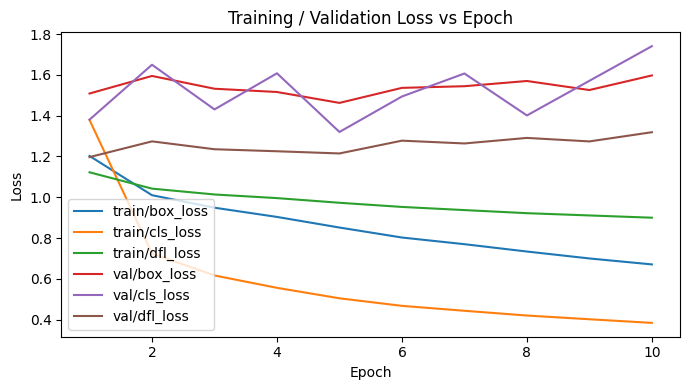

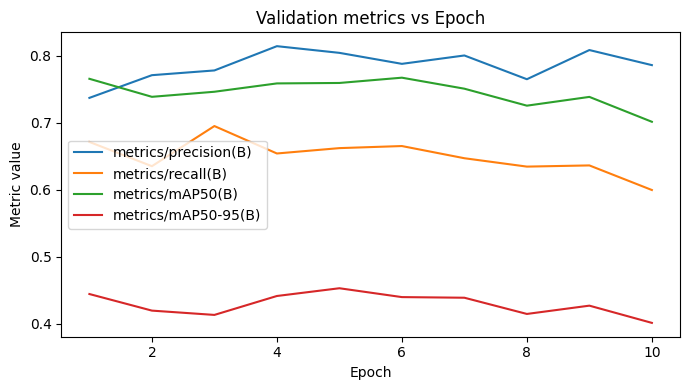


Best epoch based on 'metrics/mAP50-95(B)':


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
4,5,535.15,0.85156,0.50445,0.973,0.8043,0.66207,0.75934,0.45287,1.4628,1.32024,1.21486,0.000863,0.000863,0.000863


In [17]:
# ==========================================
# Cell 7: Visualize training metrics/results
# ==========================================

import glob

results_csv = None

if "save_dir" in globals():
    cand = os.path.join(save_dir, "results.csv")
    if os.path.exists(cand):
        results_csv = cand

if results_csv is None:
    # fallback: last YOLO run in RUN_ROOT
    exp_dirs = sorted(
        glob.glob(os.path.join(RUN_ROOT, "wildlife_det*")),
        key=os.path.getmtime
    )
    if not exp_dirs:
        raise FileNotFoundError("No YOLO run folder found in RUN_ROOT.")
    save_dir = exp_dirs[-1]
    results_csv = os.path.join(save_dir, "results.csv")

print("Using results from:", results_csv)

df = pd.read_csv(results_csv)
print("Columns:", list(df.columns))

# ---------- plot losses ----------
loss_cols = [c for c in df.columns if "loss" in c.lower()]
if loss_cols:
    plt.figure(figsize=(7, 4))
    for c in loss_cols:
        plt.plot(df["epoch"], df[c], label=c)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training / Validation Loss vs Epoch")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No loss columns found in results.csv")

# ---------- plot metrics ----------
metric_cols = [c for c in df.columns if c.startswith("metrics/")]
if metric_cols:
    plt.figure(figsize=(7, 4))
    for c in metric_cols:
        plt.plot(df["epoch"], df[c], label=c)
    plt.xlabel("Epoch")
    plt.ylabel("Metric value")
    plt.title("Validation metrics vs Epoch")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No metrics columns found in results.csv")

# ---------- show best epoch row ----------
best_col = None
for cand in ["metrics/mAP50-95(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)", "metrics/mAP50(B)"]:
    if cand in df.columns:
        best_col = cand
        break

if best_col is not None:
    best_idx = df[best_col].idxmax()
    print(f"\nBest epoch based on '{best_col}':")
    display(df.loc[[best_idx]])
else:
    print("\nShowing last epoch row:")
    display(df.tail(1))


In [20]:
# ========================================================
# Cell 8: Feature extraction + helper functions for MOT
# ========================================================

def extract_color_hist(img, bbox, bins=(16, 16, 16)):
    x1, y1, x2, y2 = [int(v) for v in bbox]
    h, w = img.shape[:2]
    x1 = max(0, min(x1, w - 1))
    y1 = max(0, min(y1, h - 1))
    x2 = max(0, min(x2, w - 1))
    y2 = max(0, min(y2, h - 1))
    if x2 <= x1 or y2 <= y1:
        return np.zeros(bins[0] * bins[1] * bins[2], dtype=np.float32)

    patch = img[y1:y2, x1:x2]
    if patch.size == 0:
        return np.zeros(bins[0] * bins[1] * bins[2], dtype=np.float32)

    hsv = cv2.cvtColor(patch, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
                        [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten().astype(np.float32)
    return hist

def cosine_distance(f1, f2):
    if f1 is None or f2 is None:
        return 1.0
    f1 = np.asarray(f1, dtype=np.float32)
    f2 = np.asarray(f2, dtype=np.float32)
    dot = float(np.dot(f1, f2))
    n1 = float(np.linalg.norm(f1)) + 1e-6
    n2 = float(np.linalg.norm(f2)) + 1e-6
    return 1.0 - dot / (n1 * n2)


In [21]:
# ==========================================
# Cell 9: Define hybrid multi-object tracker
# ==========================================

class Track:
    def __init__(self, track_id, bbox, feature, frame_idx, cls=None, dt=1.0):
        self.id = track_id
        self.bbox = bbox
        self.feature = feature
        self.last_frame = frame_idx
        self.age = 1
        self.hits = 1
        self.misses = 0
        self.history = []
        self.cls = cls  # store latest class id for this track

        cx = (bbox[0] + bbox[2]) / 2.0
        cy = (bbox[1] + bbox[3]) / 2.0

        self.kf = KalmanFilter(dim_x=4, dim_z=2)
        self.kf.x = np.array([cx, cy, 0., 0.], dtype=float)
        self.kf.F = np.array([[1, 0, dt, 0],
                              [0, 1, 0, dt],
                              [0, 0, 1, 0],
                              [0, 0, 0, 1]], dtype=float)
        self.kf.H = np.array([[1, 0, 0, 0],
                              [0, 1, 0, 0]], dtype=float)
        self.kf.P *= 50.0
        self.kf.R *= 2.0
        self.kf.Q *= 0.01

    def predict(self):
        self.kf.predict()
        x, y, vx, vy = self.kf.x
        return x, y

    def update(self, bbox, feature, frame_idx, cls=None):
        self.bbox = bbox
        self.feature = feature
        self.last_frame = frame_idx
        self.age += 1
        self.hits += 1
        self.misses = 0

        if cls is not None:
            self.cls = int(cls)

        cx = (bbox[0] + bbox[2]) / 2.0
        cy = (bbox[1] + bbox[3]) / 2.0
        z = np.array([cx, cy])
        self.kf.update(z)

    def mark_missed(self):
        self.misses += 1
        self.age += 1

    def get_predicted_center(self):
        x, y, vx, vy = self.kf.x
        return x, y

class MultiObjectTracker:
    def __init__(self,
                 max_missed=15,
                 motion_weight=0.4,
                 appearance_weight=0.6,
                 max_match_distance=0.8):
        self.next_id = 1
        self.tracks = []
        self.max_missed = max_missed
        self.motion_weight = motion_weight
        self.appearance_weight = appearance_weight
        self.max_match_distance = max_match_distance

    def _compute_cost_matrix(self, tracks, detections):
        if not tracks or not detections:
            return np.zeros((len(tracks), len(detections)), dtype=float)

        T = len(tracks)
        D = len(detections)
        cost = np.zeros((T, D), dtype=float)

        for i, trk in enumerate(tracks):
            px, py = trk.get_predicted_center()
            for j, det in enumerate(detections):
                cx, cy = det["center"]
                f = det["feature"]

                dx = px - cx
                dy = py - cy
                motion_dist = math.sqrt(dx * dx + dy * dy) / 100.0
                app_dist = cosine_distance(trk.feature, f)
                total = self.motion_weight * motion_dist + self.appearance_weight * app_dist
                cost[i, j] = total

        return cost

    def update(self, detections, frame_idx):
        # 1) predict
        for trk in self.tracks:
            trk.predict()

        # 2) match
        if self.tracks and detections:
            C = self._compute_cost_matrix(self.tracks, detections)
            row_idx, col_idx = linear_sum_assignment(C)
            matches = []
            unmatched_tracks = set(range(len(self.tracks)))
            unmatched_dets = set(range(len(detections)))

            for r, c in zip(row_idx, col_idx):
                if C[r, c] > self.max_match_distance:
                    continue
                matches.append((r, c))
                unmatched_tracks.discard(r)
                unmatched_dets.discard(c)
        else:
            matches = []
            unmatched_tracks = set(range(len(self.tracks)))
            unmatched_dets = set(range(len(detections)))

        # 3) update matched & unmatched
        for t_idx, d_idx in matches:
            trk = self.tracks[t_idx]
            det = detections[d_idx]
            trk.update(det["bbox"], det["feature"], frame_idx, det.get("cls"))

        for t_idx in unmatched_tracks:
            self.tracks[t_idx].mark_missed()

        for d_idx in unmatched_dets:
            det = detections[d_idx]
            new_trk = Track(
                self.next_id,
                det["bbox"],
                det["feature"],
                frame_idx,
                cls=det.get("cls")
            )
            self.tracks.append(new_trk)
            self.next_id += 1

        self.tracks = [t for t in self.tracks if t.misses <= self.max_missed]
        return self.tracks


In [22]:
# ==================================================
# Cell 10: Run tracking & save videos + tracks.csv
# ==================================================

# Ensure device is defined (fixes NameError)
DEVICE = 0 if torch.cuda.is_available() else "cpu"
print("Tracking running on device:", DEVICE)

tracker = MultiObjectTracker(
    max_missed=15,
    motion_weight=0.4,
    appearance_weight=0.6,
    max_match_distance=0.8
)

# -------- class-name mapping from YOLO model --------
raw_names = getattr(det_model.model, "names", {})
if isinstance(raw_names, dict):
    CLASS_NAMES = {int(k): v for k, v in raw_names.items()}
else:
    CLASS_NAMES = {i: n for i, n in enumerate(raw_names)}

# OPTIONAL: rename classes for display (edit based on your dataset)
CLASS_NAMES.update({
    0: "deer",
    1: "horse",
    2: "pig"
})

def get_track_label(trk):
    cls_id = getattr(trk, "cls", None)
    cls_name = CLASS_NAMES.get(cls_id, f"cls{cls_id}") if cls_id is not None else "unknown"
    return f"{cls_name} ID {trk.id}"

all_tracks_records = []   # will save to CSV

def run_on_split(split_name, seq_dict):
    global all_tracks_records

    for seq_name, paths in seq_dict.items():
        video_path = paths["video"]
        if video_path is None or not os.path.exists(video_path):
            print(f"Skipping {seq_name}: No video found")
            continue

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Unable to open: {video_path}")
            continue

        fps = cap.get(cv2.CAP_PROP_FPS) or 25
        w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        out_path = os.path.join(OUTPUT_DIR, f"{split_name}_{seq_name}_tracked.mp4")
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out_writer = cv2.VideoWriter(out_path, fourcc, fps, (w, h))

        print(f"\n▶ Processing {split_name} → {seq_name}")

        frame_idx = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            frame_idx += 1

            results = det_model.predict(
                source=frame,
                imgsz=640,
                conf=0.4,
                verbose=False,
                device=DEVICE
            )

            detections = []
            for r in results:
                if r.boxes is None or len(r.boxes) == 0: 
                    continue
                for box in r.boxes:
                    cls = int(box.cls)
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    cx = (x1 + x2) / 2
                    cy = (y1 + y2) / 2
                    feat = extract_color_hist(frame, (x1,y1,x2,y2))

                    detections.append({
                        "bbox": (x1,y1,x2,y2),
                        "center": (cx,cy),
                        "cls": cls,
                        "feature": feat
                    })

            tracks = tracker.update(detections, frame_idx)

            # Draw Bboxes + ID + Class name
            for trk in tracks:
                x1,y1,x2,y2 = map(int, trk.bbox)
                cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 3)     # thicker box
                label = get_track_label(trk)                            # "deer ID2"
                cv2.putText(frame, label, (x1, y1-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.1,(0,255,0), 2)

                all_tracks_records.append([
                    split_name, seq_name, frame_idx, trk.id, trk.cls,
                    x1,y1,x2,y2, trk.hits, trk.misses
                ])

            out_writer.write(frame)

        cap.release()
        out_writer.release()
        print(f"✔ Saved → {out_path}")

# Run tracking on Train + Test
run_on_split("Train", train_seqs)
run_on_split("Test",  test_seqs)

# Save CSV results
tracks_df = pd.DataFrame(
    all_tracks_records,
    columns=["split","seq","frame","track_id","cls","x1","y1","x2","y2","hits","misses"]
)
csv_path = os.path.join(OUTPUT_DIR, "tracks.csv")
tracks_df.to_csv(csv_path, index=False)

print("\n📄 Tracking results saved →", csv_path)
tracks_df.head()


Tracking running on device: 0

▶ Processing Train → deer_1
✔ Saved → /kaggle/working/wildlife_tracking/Train_deer_1_tracked.mp4

▶ Processing Train → deer_2
✔ Saved → /kaggle/working/wildlife_tracking/Train_deer_2_tracked.mp4

▶ Processing Train → deer_3
✔ Saved → /kaggle/working/wildlife_tracking/Train_deer_3_tracked.mp4

▶ Processing Train → deer_4
✔ Saved → /kaggle/working/wildlife_tracking/Train_deer_4_tracked.mp4

▶ Processing Train → deer_7
✔ Saved → /kaggle/working/wildlife_tracking/Train_deer_7_tracked.mp4

▶ Processing Train → horse_3
✔ Saved → /kaggle/working/wildlife_tracking/Train_horse_3_tracked.mp4

▶ Processing Train → horse_4
✔ Saved → /kaggle/working/wildlife_tracking/Train_horse_4_tracked.mp4

▶ Processing Train → horse_5
✔ Saved → /kaggle/working/wildlife_tracking/Train_horse_5_tracked.mp4

▶ Processing Train → horse_6
✔ Saved → /kaggle/working/wildlife_tracking/Train_horse_6_tracked.mp4

▶ Processing Train → horse_7
✔ Saved → /kaggle/working/wildlife_tracking/Train_

,split,seq,frame,track_id,cls,x1,y1,x2,y2,hits,misses
0,Train,deer_1,1,1,0,1934,541,2179,970,1,0
1,Train,deer_1,1,2,0,981,550,1291,1039,1,0
2,Train,deer_1,1,3,0,1217,558,1512,986,1,0
3,Train,deer_1,1,4,0,1510,600,1732,992,1,0
4,Train,deer_1,1,5,0,1614,526,1895,940,1,0


In [24]:
# ===========================================
# Cell 11: Evaluate tracking with GT (MOT-like)
# ===========================================

def bbox_iou(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw = max(0, ix2 - ix1)
    ih = max(0, iy2 - iy1)
    inter = iw * ih
    area_a = max(0, ax2 - ax1) * max(0, ay2 - ay1)
    area_b = max(0, bx2 - bx1) * max(0, by2 - by1)
    union = area_a + area_b - inter + 1e-6
    return inter / union

def evaluate_sequence(seq_name, split_name, gt_path, tracks_df, iou_thresh=0.5):
    gt_df = load_gt_file(gt_path)
    if gt_df.empty:
        return None

    sub_tracks = tracks_df[(tracks_df["split"] == split_name) &
                           (tracks_df["seq"] == seq_name)].copy()
    if sub_tracks.empty:
        return None

    frames = sorted(gt_df["frame"].unique().tolist())
    track_map = {}  # gt_id -> assigned track_id

    total_gt = 0
    total_pred = 0
    matches = 0
    id_switches = 0

    for f in frames:
        gt_f = gt_df[gt_df["frame"] == f]
        tr_f = sub_tracks[sub_tracks["frame"] == f]

        gt_boxes = gt_f[["x", "y", "w", "h"]].values
        gt_ids   = gt_f["gt_id"].values

        pred_boxes = tr_f[["x1", "y1", "x2", "y2"]].values
        pred_ids   = tr_f["track_id"].values

        total_gt   += len(gt_boxes)
        total_pred += len(pred_boxes)

        if len(gt_boxes) == 0 or len(pred_boxes) == 0:
            continue

        # cost = 1 - IoU
        cost = np.zeros((len(gt_boxes), len(pred_boxes)), dtype=float)
        for i in range(len(gt_boxes)):
            x, y, w, h = gt_boxes[i]
            g_box = (x, y, x + w, y + h)
            for j in range(len(pred_boxes)):
                p_box = pred_boxes[j]
                cost[i, j] = 1.0 - bbox_iou(g_box, p_box)

        row_idx, col_idx = linear_sum_assignment(cost)
        for r, c in zip(row_idx, col_idx):
            iou = 1.0 - cost[r, c]
            if iou < iou_thresh:
                continue
            gid = int(gt_ids[r])
            tid = int(pred_ids[c])
            matches += 1
            if gid in track_map and track_map[gid] != tid:
                id_switches += 1
            track_map[gid] = tid

    fp = max(0, total_pred - matches)
    fn = max(0, total_gt - matches)

    mota = 1.0 - (fp + fn + id_switches) / (total_gt + 1e-6)
    precision = matches / (total_pred + 1e-6)
    recall    = matches / (total_gt + 1e-6)

    return {
        "split": split_name,
        "seq": seq_name,
        "gt": total_gt,
        "pred": total_pred,
        "matches": matches,
        "FP": fp,
        "FN": fn,
        "IDsw": id_switches,
        "MOTA": mota,
        "precision": precision,
        "recall": recall
    }

results = []

for split_name, seq_dict in [("Train", train_seqs), ("Test", test_seqs)]:
    for seq_name, paths in seq_dict.items():
        gt_path = paths["gt"]
        if gt_path is None or not os.path.exists(gt_path):
            continue
        res = evaluate_sequence(seq_name, split_name, gt_path, tracks_df, iou_thresh=0.5)
        if res is not None:
            results.append(res)

metrics_df = pd.DataFrame(results)
metrics_path = os.path.join(OUTPUT_DIR, "tracking_metrics.csv")
metrics_df.to_csv(metrics_path, index=False)

print("\nPer-sequence tracking metrics:")
display(metrics_df)
print("\nSaved metrics to:", metrics_path)



Per-sequence tracking metrics:


,split,seq,gt,pred,matches,FP,FN,IDsw,MOTA,precision,recall
0,Train,deer_1,2412,2948,2352,596,60,118,0.679104,0.797829,0.975124
1,Train,deer_2,7214,8456,6711,1745,503,127,0.670779,0.793638,0.930274
2,Train,deer_3,4861,5691,4671,1020,190,56,0.739560,0.820770,0.960913
3,Train,deer_4,2462,2928,2416,512,46,22,0.764419,0.825137,0.981316
4,Train,deer_7,4989,5768,4909,859,80,60,0.799759,0.851075,0.983965
5,Train,horse_3,15930,20016,15513,4503,417,292,0.672819,0.775030,0.973823
6,Train,horse_4,3731,3744,3645,99,86,0,0.950415,0.973558,0.976950
7,Train,horse_5,5603,6168,5414,754,189,37,0.825094,0.877756,0.966268
8,Train,horse_6,7879,9361,7778,1583,101,108,0.772560,0.830894,0.987181
9,Train,horse_7,10091,11334,9880,1454,211,69,0.828164,0.871713,0.979090



Saved metrics to: /kaggle/working/wildlife_tracking/tracking_metrics.csv


In [25]:
import shutil

# Folder you want to zip
folder_path = "/kaggle/working/"   # change to your folder

# Output zip file path (without .zip extension)
zip_output = "/kaggle/"

# Create zip
shutil.make_archive(zip_output, 'zip', folder_path)

print("Zipped successfully:", zip_output + "output.zip")


Zipped successfully: /kaggle/.zip


In [27]:
!zip -r output2.zip /kaggle/working/runs/detect/wildlife_det > /dev/null
